In [1]:
%reload_kedro

2023-08-03 20:11:51,244 - kedro.extras.extensions.ipython - INFO - No path argument was provided. Using: /Users/gpalazzo/Desktop/dev/mba_Otavio
2023-08-03 20:11:51,427 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2023-08-03 20:11:51,521 - kedro.extras.extensions.ipython - INFO - ** Kedro project itaete_buy_prop
2023-08-03 20:11:51,522 - kedro.extras.extensions.ipython - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`
2023-08-03 20:11:51,528 - kedro.extras.extensions.ipython - INFO - Registered line magic `run_viz`


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import array #useful to parse values

In [4]:
model = catalog.load("logreg_fitted_model")

X_test = catalog.load("master_table_teste_ftes")
y_test = catalog.load("master_table_teste_tgt")
y_pred = catalog.load("logreg_model_predict")

df_model_rpt = catalog.load("logreg_model_relatorio")

2023-08-03 20:11:52,154 - kedro.io.data_catalog - INFO - Loading data from `logreg_fitted_model` (PickleDataSet)...
2023-08-03 20:11:52,198 - kedro.io.data_catalog - INFO - Loading data from `master_table_teste_ftes` (ParquetDataSet)...
2023-08-03 20:11:52,228 - kedro.io.data_catalog - INFO - Loading data from `master_table_teste_tgt` (ParquetDataSet)...
2023-08-03 20:11:52,231 - kedro.io.data_catalog - INFO - Loading data from `logreg_model_predict` (ParquetDataSet)...
2023-08-03 20:11:52,234 - kedro.io.data_catalog - INFO - Loading data from `logreg_model_relatorio` (ParquetDataSet)...


In [5]:
_roc_auc_score = roc_auc_score(y_true=y_test, y_score=y_pred)
_roc_auc_score

0.44901315789473684

In [6]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.44      0.21      0.29        19
           1       0.42      0.69      0.52        16

    accuracy                           0.43        35
   macro avg       0.43      0.45      0.40        35
weighted avg       0.43      0.43      0.39        35



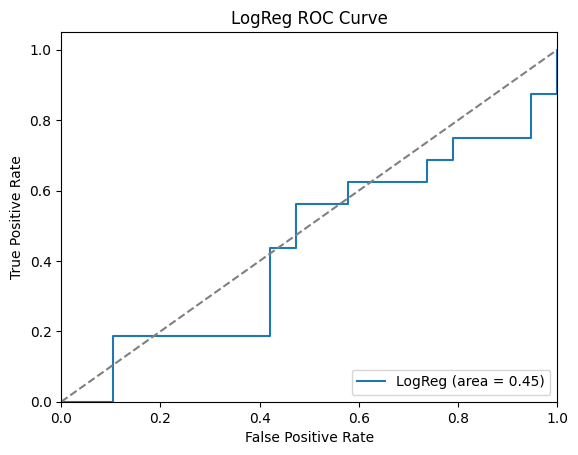

In [7]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

plt.figure()

plt.plot(fpr, tpr, label="LogReg (area = %0.2f)" % _roc_auc_score)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title("LogReg ROC Curve")
plt.legend(loc="lower right")

Text(0.5, 1.0, 'LogReg CM')

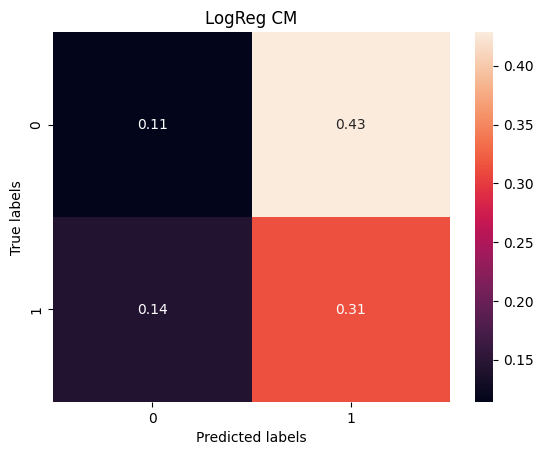

In [8]:
cm = eval(df_model_rpt["confusion_matrix"][0])

ax = plt.subplot()
plot = sns.heatmap(cm, annot=True, ax=ax)
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("LogReg CM")